IMPORTING LIBRARIES

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##PROBLEM-1

###### Problem - 1: Kalman Filter
###### Implement the Kalman Filter to estimate the level of water in the 4 tanks present in the Quadruple tank experiment, as discussed in class. The experiment is explained in detail in the reference paper (Quadruple tank process) as in the link given below.
###### Link: https://drive.google.com/file/d/1XQ-O1Rov4L_b6n1J6dJQ7_3cUy-l-ik4/view?usp=sharing
###### Please use the same parameter values as described in the paper. For the initial conditions, use the minimum-phase characteristic values. The transfer functions given in the paper can be ignored for this assignment. Q and R values have to be tuned to attain convergence of the filter and get better accuracy with the estimates. Tolerance, defined as the L2 norm between prior and posterior state vectors, has to be less than or equal to 5 X 10-3. Measurements are sampled at a time interval of 0.1s. Measurement values obtained by solving the model equations have also been uploaded in the link given below. Use them as the true measurements.
###### Link: https://docs.google.com/spreadsheets/d/10lm7KOxo6k3etXTsW5t2KYcC7d0sGUlZ/edit?usp=sharing&ouid=108491382124139074371&rtpof=true&sd=true

ANALYSING DATA FROM THE CSV FILE

In [4]:
# Load measurements from CSV file
measurements = pd.read_excel('Link 2 Measurements.xlsx')
# time_stamps = measurements['timestamp'].values
z_true = measurements[['h1', 'h2', 'h3', 'h4']].values

In [5]:
z_true[1,:4].reshape(-1,1)

array([[12.40492766],
       [12.70061798],
       [ 1.79288086],
       [ 1.40030108]])

In [6]:
measurements.head()

,h1,h2,h3,h4
0,12.400000,12.700000,1.800000,1.400000
1,12.404928,12.700618,1.792881,1.400301
2,12.409478,12.701239,1.786060,1.400592
3,12.413670,12.701863,1.779526,1.400873
4,12.417521,12.702490,1.773266,1.401145


Finding out the Kalman filter variables such as T, state matrices-A,B,C as given in research paper

In [7]:
h=[12.4,12.7,1.8,1.4]
Ar=[28,32,28,32]
ar=[0.071,0.057,0.071,0.057]
g=981.2
T=[]
for i in range(len(h)):
  Time_const=(Ar[i]/ar[i])*np.sqrt((2*h[i])/g)
  T.append(Time_const)

print(T)

[62.69699892820124, 90.32609002462239, 23.887580479237094, 29.989924232904087]


In [8]:
gamma_1=0.7
gamma_2=0.6
k1=3.33
k2=3.35

In [9]:
A=[[-1/T[0],0,(Ar[2]/(Ar[0]*T[2])),0],[0,-1/T[1],0,(Ar[3]/(Ar[1]*T[3]))],[0,0,-1/T[2],0],[0,0,0,-1/T[3]]]

In [10]:
B=[[(gamma_1*k1)/Ar[0],0],[0,(gamma_2*k2)/Ar[1]],[0,((1-gamma_2)*k2)/Ar[2]],[((1-gamma_1)*k1)/Ar[3],0]]

In [11]:
u=np.array([[3],[3]])

In [12]:
u.shape

(2, 1)

Converting A and B into np.array

In [13]:
A=np.array(A)
B=np.array(B)

Now applying Kalman Filter

In [14]:
# Initialize variables
dt = 0.1
num_tanks = 4
num_measurements = len(z_true)
# A = np.eye(num_tanks)  # Transition matrix
# B = np.eye(num_tanks)  # Input matrix
# u = np.zeros((num_tanks, num_measurements))  # Input vector
X_post = np.ones((num_tanks, 1))  # Initial state estimate
P_post = 1e5 * np.eye(num_tanks)  # Initial error covariance
Q = 8* np.eye(num_tanks)  # Process noise covariance
R = 2 * np.eye(4)  # Measurement noise covariance

# Define the measurement matrix
# H = np.eye(num_tanks)
kc=0.5
H=[[kc,0,0,0],[0,kc,0,0],[0,0,kc,0],[0,0,0,kc]]
H=np.array(H)
# Initialize lists to store values for plotting
X_post_list = []
P_post_list = []
P_pri_list = []
Kalman_gain_list = []

x_post_old = np.zeros(num_measurements)
# Kalman filter loop
for k in range(num_measurements):
    # Prediction step
    X_pri = np.dot(A, X_post) + np.dot(B, u[:].reshape(-1, 1))
    P_pri = np.dot(np.dot(A, P_post), A.T) + Q

    # Update step
    K = np.dot(np.dot(P_pri, H.T), np.linalg.inv(np.dot(np.dot(H, P_pri), H.T) + R))
    Z_est = np.dot(H, X_pri)
    E = z_true[k,:4] - Z_est.flatten()
    X_post = X_pri + np.dot(K, E.reshape(-1, 1))
    P_post = P_pri - np.dot(np.dot(K, H), P_pri)

    # Append values to the lists
    X_post_list.append(X_post.flatten())
    P_post_list.append(np.trace(P_post))
    P_pri_list.append(np.trace(P_pri))
    Kalman_gain_list.append(np.trace(K))

    # Calculate the L2 norm

    l2_norm = np.linalg.norm(x_post_old - X_post)
    x_post_old = X_post

    # Check if the L2 norm is less than or equal to the threshold
    threshold = 5e-3
    if l2_norm <= threshold:
        print(f"L2 norm converges to threshold value at {k} iteration")


    # Stop condition: X_post - X_pri approx = 0
    if np.allclose(X_post, X_pri):
        break

# Final estimated states
estimated_states = X_post.flatten()
print("Estimated states:", estimated_states)


L2 norm converges to threshold value at 11 iteration
L2 norm converges to threshold value at 12 iteration
L2 norm converges to threshold value at 13 iteration
L2 norm converges to threshold value at 14 iteration
L2 norm converges to threshold value at 15 iteration
L2 norm converges to threshold value at 16 iteration
L2 norm converges to threshold value at 17 iteration
L2 norm converges to threshold value at 18 iteration
L2 norm converges to threshold value at 19 iteration
L2 norm converges to threshold value at 20 iteration
L2 norm converges to threshold value at 21 iteration
L2 norm converges to threshold value at 22 iteration
L2 norm converges to threshold value at 23 iteration
L2 norm converges to threshold value at 24 iteration
L2 norm converges to threshold value at 25 iteration
L2 norm converges to threshold value at 26 iteration
L2 norm converges to threshold value at 27 iteration
L2 norm converges to threshold value at 28 iteration
L2 norm converges to threshold value at 29 ite

L2 norm converges to threshold value at 2086 iteration
L2 norm converges to threshold value at 2087 iteration
L2 norm converges to threshold value at 2088 iteration
L2 norm converges to threshold value at 2089 iteration
L2 norm converges to threshold value at 2090 iteration
L2 norm converges to threshold value at 2091 iteration
L2 norm converges to threshold value at 2092 iteration
L2 norm converges to threshold value at 2093 iteration
L2 norm converges to threshold value at 2094 iteration
L2 norm converges to threshold value at 2095 iteration
L2 norm converges to threshold value at 2096 iteration
L2 norm converges to threshold value at 2097 iteration
L2 norm converges to threshold value at 2098 iteration
L2 norm converges to threshold value at 2099 iteration
L2 norm converges to threshold value at 2100 iteration
L2 norm converges to threshold value at 2101 iteration
L2 norm converges to threshold value at 2102 iteration
L2 norm converges to threshold value at 2103 iteration
L2 norm co

L2 norm converges to threshold value at 3929 iteration
L2 norm converges to threshold value at 3930 iteration
L2 norm converges to threshold value at 3931 iteration
L2 norm converges to threshold value at 3932 iteration
L2 norm converges to threshold value at 3933 iteration
L2 norm converges to threshold value at 3934 iteration
L2 norm converges to threshold value at 3935 iteration
L2 norm converges to threshold value at 3936 iteration
L2 norm converges to threshold value at 3937 iteration
L2 norm converges to threshold value at 3938 iteration
L2 norm converges to threshold value at 3939 iteration
L2 norm converges to threshold value at 3940 iteration
L2 norm converges to threshold value at 3941 iteration
L2 norm converges to threshold value at 3942 iteration
L2 norm converges to threshold value at 3943 iteration
L2 norm converges to threshold value at 3944 iteration
L2 norm converges to threshold value at 3945 iteration
L2 norm converges to threshold value at 3946 iteration
L2 norm co

L2 norm converges to threshold value at 5784 iteration
L2 norm converges to threshold value at 5785 iteration
L2 norm converges to threshold value at 5786 iteration
L2 norm converges to threshold value at 5787 iteration
L2 norm converges to threshold value at 5788 iteration
L2 norm converges to threshold value at 5789 iteration
L2 norm converges to threshold value at 5790 iteration
L2 norm converges to threshold value at 5791 iteration
L2 norm converges to threshold value at 5792 iteration
L2 norm converges to threshold value at 5793 iteration
L2 norm converges to threshold value at 5794 iteration
L2 norm converges to threshold value at 5795 iteration
L2 norm converges to threshold value at 5796 iteration
L2 norm converges to threshold value at 5797 iteration
L2 norm converges to threshold value at 5798 iteration
L2 norm converges to threshold value at 5799 iteration
L2 norm converges to threshold value at 5800 iteration
L2 norm converges to threshold value at 5801 iteration
L2 norm co

L2 norm converges to threshold value at 7678 iteration
L2 norm converges to threshold value at 7679 iteration
L2 norm converges to threshold value at 7680 iteration
L2 norm converges to threshold value at 7681 iteration
L2 norm converges to threshold value at 7682 iteration
L2 norm converges to threshold value at 7683 iteration
L2 norm converges to threshold value at 7684 iteration
L2 norm converges to threshold value at 7685 iteration
L2 norm converges to threshold value at 7686 iteration
L2 norm converges to threshold value at 7687 iteration
L2 norm converges to threshold value at 7688 iteration
L2 norm converges to threshold value at 7689 iteration
L2 norm converges to threshold value at 7690 iteration
L2 norm converges to threshold value at 7691 iteration
L2 norm converges to threshold value at 7692 iteration
L2 norm converges to threshold value at 7693 iteration
L2 norm converges to threshold value at 7694 iteration
L2 norm converges to threshold value at 7695 iteration
L2 norm co

L2 norm converges to threshold value at 9706 iteration
L2 norm converges to threshold value at 9707 iteration
L2 norm converges to threshold value at 9708 iteration
L2 norm converges to threshold value at 9709 iteration
L2 norm converges to threshold value at 9710 iteration
L2 norm converges to threshold value at 9711 iteration
L2 norm converges to threshold value at 9712 iteration
L2 norm converges to threshold value at 9713 iteration
L2 norm converges to threshold value at 9714 iteration
L2 norm converges to threshold value at 9715 iteration
L2 norm converges to threshold value at 9716 iteration
L2 norm converges to threshold value at 9717 iteration
L2 norm converges to threshold value at 9718 iteration
L2 norm converges to threshold value at 9719 iteration
L2 norm converges to threshold value at 9720 iteration
L2 norm converges to threshold value at 9721 iteration
L2 norm converges to threshold value at 9722 iteration
L2 norm converges to threshold value at 9723 iteration
L2 norm co

In [15]:
# Initialize variables
dt = 0.1
num_tanks = 4
num_measurements = len(z_true)
# A = np.eye(num_tanks)  # Transition matrix
# B = np.eye(num_tanks)  # Input matrix
# u = np.zeros((num_tanks, num_measurements))  # Input vector
X_post = np.ones((num_tanks, 1))  # Initial state estimate
P_post = 1e5 * np.eye(num_tanks)  # Initial error covariance
Q = 0.1 * np.eye(num_tanks)  # Process noise covariance
R = 100 * np.eye(2)  # Measurement noise covariance

# Define the measurement matrix
# H = np.eye(num_tanks)
kc=0.5
H=[[kc,0,0,0],[0,kc,0,0]]
H=np.array(H)
# Initialize lists to store values for plotting
X_post_list = []
P_post_list = []
P_pri_list = []
Kalman_gain_list = []

x_post_old = np.zeros(num_measurements)
# Kalman filter loop
for k in range(num_measurements):
    # Prediction step
    X_pri = np.dot(A, X_post) + np.dot(B, u[:].reshape(-1, 1))
    P_pri = np.dot(np.dot(A, P_post), A.T) + Q

    # Update step
    K = np.dot(np.dot(P_pri, H.T), np.linalg.inv(np.dot(np.dot(H, P_pri), H.T) + R))
    Z_est = np.dot(H, X_pri)
    E = z_true[k,:2] - Z_est.flatten()
    X_post = X_pri + np.dot(K, E.reshape(-1, 1))
    P_post = P_pri - np.dot(np.dot(K, H), P_pri)

    # Append values to the lists
    X_post_list.append(X_post.flatten())
    P_post_list.append(np.trace(P_post))
    P_pri_list.append(np.trace(P_pri))
    Kalman_gain_list.append(np.trace(K))


    # Calculate the L2 norm

    l2_norm = np.linalg.norm(x_post_old - X_post)
    x_post_old = X_post

    # Check if the L2 norm is less than or equal to the threshold
    threshold = 5e-3
    if l2_norm <= threshold:
        print(f"L2 norm converges to threshold value at {k} iteration")
        break


    # Stop condition: X_post - X_pri approx = 0
    if np.allclose(X_post, X_pri):
        break

# Final estimated states
estimated_states = X_post.flatten()
print("Estimated states:", estimated_states)


L2 norm converges to threshold value at 4 iteration
Estimated states: [0.25760037 0.19561352 0.13777148 0.09062095]


In [16]:
from pandas.core.algorithms import validate_indices
# Initialize variables
dt = 0.1
num_tanks = 4
num_measurements = len(z_true)
# A = np.eye(num_tanks)  # Transition matrix
# B = np.eye(num_tanks)  # Input matrix
# u = np.zeros((num_tanks, num_measurements))  # Input vector
X_post_0 = z_true[1,:4].reshape(-1,1)  # Initial state estimate
P_post_0 = 1e5 * np.eye(num_tanks)  # Initial error covariance
Q = 0.1 * np.eye(num_tanks)  # Process noise covariance
R = 100 * np.eye(2)  # Measurement noise covariance

# Initial state of the tank heights
h0 = np.array([[12.4, 12.7, 1.8, 1.4]]).T

# Define the measurement matrix
kc=0.5
H=[[kc,0,0,0],[0,kc,0,0]]
H=np.array(H)

# Initialize lists to store values for plotting
X_post_list = []
X_pri_list=[]
P_post_list = []
P_pri_list = []
Kalman_gain_list = []
Innovation_store_list=[]
Residue_store_list=[]

# x_post_old = np.zeros(num_measurements)
# Kalman filter loop
for k in range(num_measurements):
  # Voltage obtained using H and true height measurements
  V_in=np.dot(H,z_true[k,:4].reshape(-1,1))

  # Prediction steps
  #Height prior calculation as mentioned in paper
  X_pri = (np.dot(A, (X_post_0-h0)) + np.dot(B, (V_in-u)))*dt
  #Getting actual height by adding previous iteration height
  X_pri+=h0

  #Updating h0
  h0 = z_true[k,:4].reshape(-1,1)

  #Now calculating process noise covariance matrix
  P_pri = (np.dot(np.dot(A, P_post_0), A.T) + Q)*dt**2

  # Update step starts
  #Calculating Kalman gain
  K = np.dot(np.dot(P_pri, H.T), np.linalg.inv(np.dot(np.dot(H, P_pri), H.T) + R))

  #Estimating the output voltage at each timestamp
  V_out=np.dot(H,z_true[k,:4].reshape(-1,1))
  Z_est = np.dot(H, X_pri)

  #Calculating error between true and predicted voltage
  E = V_out - Z_est

  #Kalman height update step
  X_post = X_pri + np.dot(K, E)
  #Kalman process noise covariance updation
  P_post = P_pri - np.dot(np.dot(K, H), P_pri)

  # Append values to the lists
  X_post_list.append(X_post.flatten())
  P_post_list.append(np.trace(P_post))
  X_pri_list.append(X_pri.flatten())
  P_pri_list.append(np.trace(P_pri))
  Kalman_gain_list.append(np.trace(K))
  Innovation_store_list.append(E.flatten())
  Residue_store_list.append((z_true[k, :2].reshape(-1,1) - H.dot(X_post)).tolist())

  X_post_0=X_post
  P_post_0=P_post

  # Calculate the L2 norm

  l2_norm = np.linalg.norm(X_pri - X_post)
  # Check if the L2 norm is less than or equal to the threshold
  threshold = 5e-3
  if l2_norm <= threshold:
    print(f"L2 norm converges to threshold value at {k} iteration with threshhold {l2_norm}")
  else:
    print(f'L2 norm is {l2_norm} and still Kalman filter cant achieve threshhold value error')



  # # Stop condition: X_post - X_pri approx = 0
  # if np.allclose(X_post, X_pri):
  #     break

# Final estimated states
estimated_states = X_post.flatten()
print("Estimated states are:", estimated_states)


L2 norm converges to threshold value at 0 iteration with threshhold 0.00019672553145984792
L2 norm converges to threshold value at 1 iteration with threshhold 7.778611876853733e-08
L2 norm converges to threshold value at 2 iteration with threshhold 7.541628734387474e-08
L2 norm converges to threshold value at 3 iteration with threshhold 7.610588804804021e-08
L2 norm converges to threshold value at 4 iteration with threshhold 7.676701123254902e-08
L2 norm converges to threshold value at 5 iteration with threshhold 7.739980985718585e-08
L2 norm converges to threshold value at 6 iteration with threshhold 7.800489451816906e-08
L2 norm converges to threshold value at 7 iteration with threshhold 7.858293042500281e-08
L2 norm converges to threshold value at 8 iteration with threshhold 7.913461669931728e-08
L2 norm converges to threshold value at 9 iteration with threshhold 7.966068684353724e-08
L2 norm converges to threshold value at 10 iteration with threshhold 8.016188957532616e-08
L2 norm 

L2 norm converges to threshold value at 1225 iteration with threshhold 8.423284640018263e-08
L2 norm converges to threshold value at 1226 iteration with threshhold 8.423284640018263e-08
L2 norm converges to threshold value at 1227 iteration with threshhold 8.423284640018263e-08
L2 norm converges to threshold value at 1228 iteration with threshhold 8.423284640018263e-08
L2 norm converges to threshold value at 1229 iteration with threshhold 8.423284640018263e-08
L2 norm converges to threshold value at 1230 iteration with threshhold 8.423284640018263e-08
L2 norm converges to threshold value at 1231 iteration with threshhold 8.423284640018263e-08
L2 norm converges to threshold value at 1232 iteration with threshhold 8.423284640018263e-08
L2 norm converges to threshold value at 1233 iteration with threshhold 8.423284640018263e-08
L2 norm converges to threshold value at 1234 iteration with threshhold 8.423284640018263e-08
L2 norm converges to threshold value at 1235 iteration with threshhold

L2 norm converges to threshold value at 1871 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 1872 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 1873 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 1874 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 1875 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 1876 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 1877 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 1878 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 1879 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 1880 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 1881 iteration with threshhold

L2 norm converges to threshold value at 2227 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 2228 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 2229 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 2230 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 2231 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 2232 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 2233 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 2234 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 2235 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 2236 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 2237 iteration with threshhold

L2 norm converges to threshold value at 3389 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 3390 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 3391 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 3392 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 3393 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 3394 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 3395 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 3396 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 3397 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 3398 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 3399 iteration with threshhold

L2 norm converges to threshold value at 4231 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 4232 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 4233 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 4234 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 4235 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 4236 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 4237 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 4238 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 4239 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 4240 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 4241 iteration with threshhold

L2 norm converges to threshold value at 5652 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 5653 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 5654 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 5655 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 5656 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 5657 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 5658 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 5659 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 5660 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 5661 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 5662 iteration with threshhold

L2 norm converges to threshold value at 6518 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 6519 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 6520 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 6521 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 6522 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 6523 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 6524 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 6525 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 6526 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 6527 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 6528 iteration with threshhold

L2 norm converges to threshold value at 8059 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8060 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8061 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8062 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8063 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8064 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8065 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8066 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8067 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8068 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8069 iteration with threshhold

L2 norm converges to threshold value at 8755 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8756 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8757 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8758 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8759 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8760 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8761 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8762 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8763 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8764 iteration with threshhold 8.423284864743751e-08
L2 norm converges to threshold value at 8765 iteration with threshhold

In [17]:
X_pri.shape

(4, 1)

In [18]:
X_post.shape

(4, 1)

In [19]:
K.shape

(4, 2)

In [20]:
E.shape

(2, 1)

In [21]:
time_steps=np.arange(0,10001)
time_steps

array([    0,     1,     2, ...,  9998,  9999, 10000])

In [22]:
def Plot_graphs(tank_num, time_steps, original_data, Kalman_results, measurements, tank_name, marker):
    """

    Parameters of function:
        tank_num (int): The subplot number for the current tank.
        time_steps (numpy.ndarray): Array of time steps.
        original_data (numpy.ndarray): Array of original tank data.
        Kalman_results (numpy.ndarray): Array of filter results for the current tank.
        measurements (numpy.ndarray): Array of tank measurements for the current tank.
        tank_name (str): Name of the current tank.
        marker (str): Marking the tank wise plot

    Returns:
        None
    """
    # Create a subplot for the current tank
    plt.subplot(1, 4, tank_num)
    # Plot the original tank data
    plt.plot(time_steps, original_data, label='Original Data', color='blue')
    # Plot the filter results
    plt.plot(time_steps, Kalman_results, label='Filter Results', color='red')
    # Plot the tank measurements
    plt.scatter(time_steps, measurements, label='Measurements', color='green', marker=marker, s = 30)
    # Set the x-axis label
    plt.xlabel('Time Steps')
    # Set the y-axis label
    plt.ylabel('Tank Level')
    # Set the title for the subplot
    plt.title(tank_name)
    # Show the legend
    plt.legend()

In [23]:
(np.array(X_post_list)[:, 0]).shape

(10001,)

In [24]:
z_true[:,:1].shape

(10001, 1)

X_POST PLOT

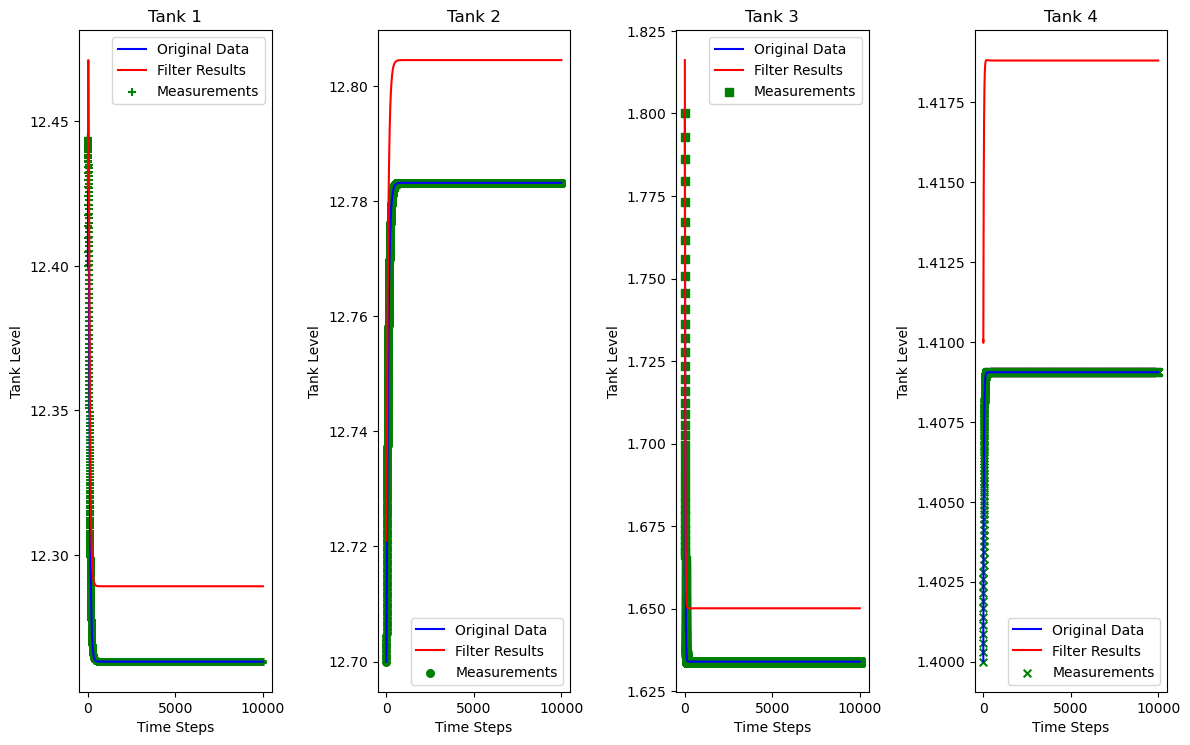

In [25]:
# Initialize the plot for original data and Kalman filter results
plt.figure(figsize=(12, 8))
# plt.suptitle(f'Original and Kalman Filter Results for tuner noice : {i} & tuner error covariance : {j}')

Plot_graphs(1, time_steps, z_true[:,:1], np.array(X_post_list)[:, 0], z_true[:,:1], 'Tank 1', '+')
Plot_graphs(2, time_steps, z_true[:,1:2], np.array(X_post_list)[:, 1], z_true[:,1:2], 'Tank 2', 'o')
Plot_graphs(3, time_steps, z_true[:,2:3], np.array(X_post_list)[:, 2], z_true[:,2:3], 'Tank 3', 's')
Plot_graphs(4, time_steps, z_true[:,3:4], np.array(X_post_list)[:, 3], z_true[:,3:4], 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

X_PRI PLOT

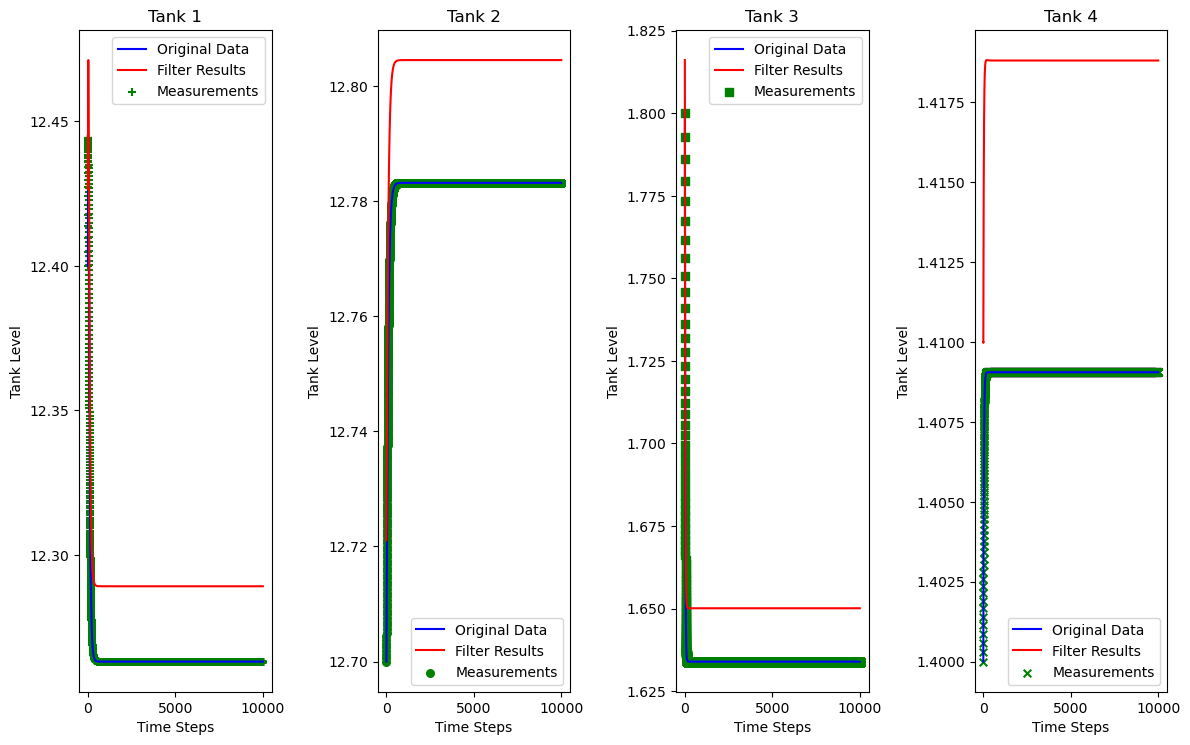

In [26]:
# Initialize the plot for original data and Kalman filter results
plt.figure(figsize=(12, 8))
# plt.suptitle(f'Original and Kalman Filter Results for tuner noice : {i} & tuner error covariance : {j}')

Plot_graphs(1, time_steps, z_true[:,:1], np.array(X_pri_list)[:, 0], z_true[:,:1], 'Tank 1', '+')
Plot_graphs(2, time_steps, z_true[:,1:2], np.array(X_pri_list)[:, 1], z_true[:,1:2], 'Tank 2', 'o')
Plot_graphs(3, time_steps, z_true[:,2:3], np.array(X_pri_list)[:, 2], z_true[:,2:3], 'Tank 3', 's')
Plot_graphs(4, time_steps, z_true[:,3:4], np.array(X_pri_list)[:, 3], z_true[:,3:4], 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

P_PRIOR PLOT

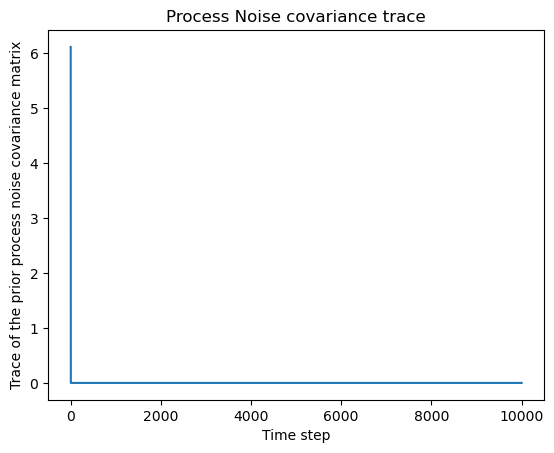

In [27]:
#  P_prior matrix's trace plot
P_prior_plot = [P_pri_list[i] for i in time_steps]

plt.plot(time_steps,P_prior_plot)
plt.title("Process Noise covariance trace")
plt.xlabel('Time step')
plt.ylabel('Trace of the prior process noise covariance matrix')
plt.show()

P_POST PLOT

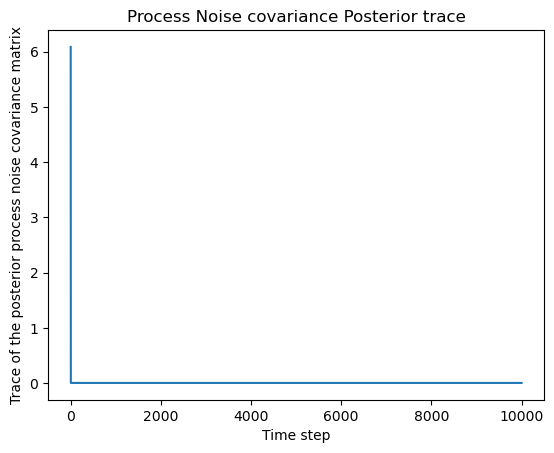

In [28]:
#  P_post matrix's trace plot
P_post_plot = [P_post_list[i] for i in time_steps]

plt.plot(time_steps,P_post_plot)
plt.title("Process Noise covariance Posterior trace")
plt.xlabel('Time step')
plt.ylabel('Trace of the posterior process noise covariance matrix')
plt.show()

KALMAN GAIN MATRIX PLOT

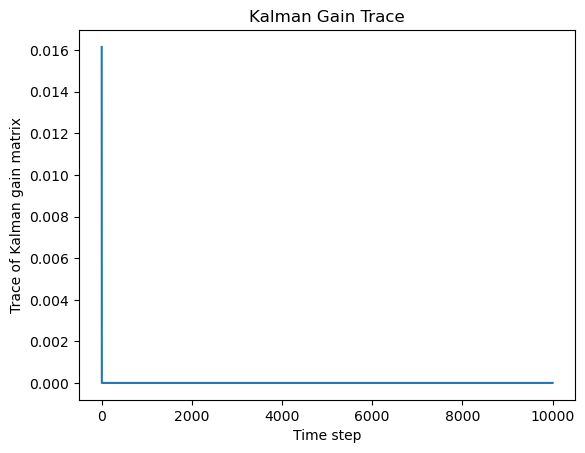

In [29]:
# KALMAN_GAIN trace plot
Kalman_gain_plot = [Kalman_gain_list[i] for i in time_steps]

plt.plot(time_steps,Kalman_gain_plot)
plt.title("Kalman Gain Trace")
plt.xlabel('Time step')
plt.ylabel('Trace of Kalman gain matrix')
plt.show()

INNOVATOR TRACE PLOT

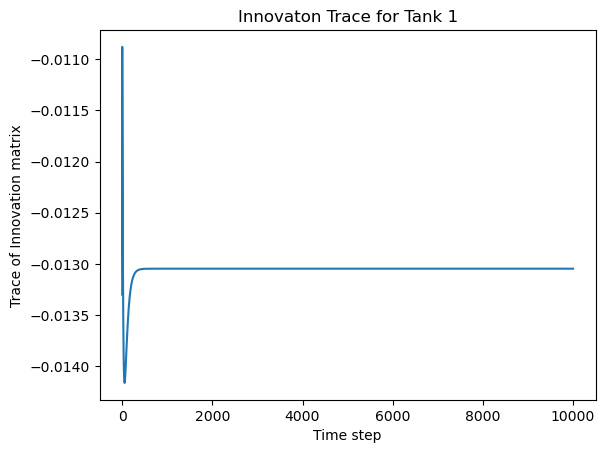

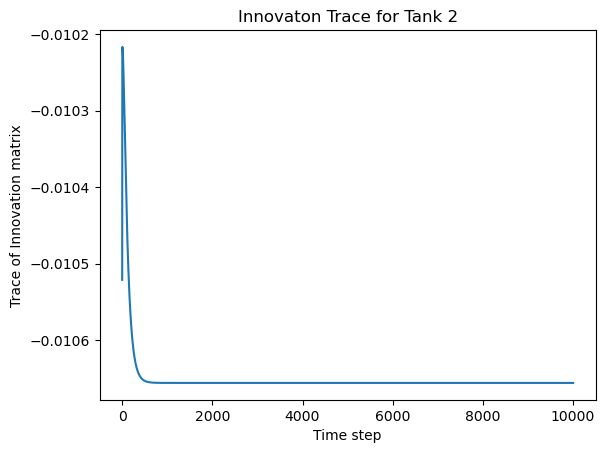

In [30]:
# KALMAN_GAIN trace plot
Innovator_plot_tank_one = [Innovation_store_list[i][0] for i in time_steps]

plt.plot(time_steps,Innovator_plot_tank_one)
plt.title("Innovaton Trace for Tank 1")
plt.xlabel('Time step')
plt.ylabel('Trace of Innovation matrix')
plt.show()

# KALMAN_GAIN trace plot
Innovator_plot_tank_two = [Innovation_store_list[i][1] for i in time_steps]

plt.plot(time_steps,Innovator_plot_tank_two)
plt.title("Innovaton Trace for Tank 2")
plt.xlabel('Time step')
plt.ylabel('Trace of Innovation matrix')
plt.show()

RESIDUE PLOT

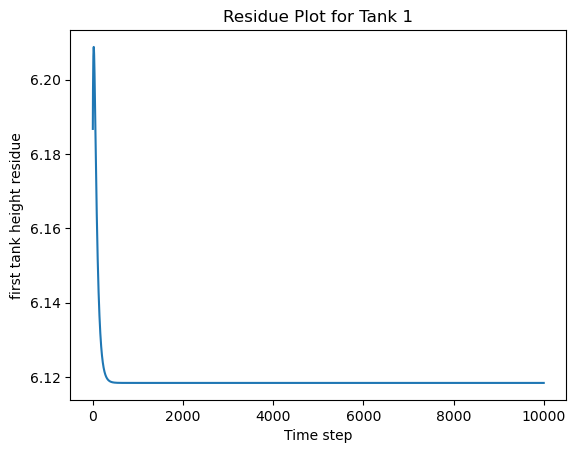

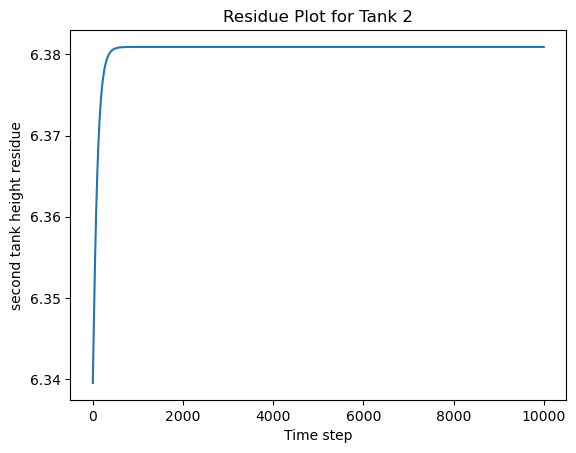

In [31]:
# Residue plot
Residue_plot_tank_one = [Residue_store_list[i][0][0] for i in time_steps]

plt.plot(time_steps,Residue_plot_tank_one)
plt.title("Residue Plot for Tank 1")
plt.xlabel('Time step')
plt.ylabel('first tank height residue')
plt.show()

# Residue Plot for Tank 2
Residue_plot_tank_two = [Residue_store_list[i][1][0] for i in time_steps]

plt.plot(time_steps,Residue_plot_tank_two)
plt.title("Residue Plot for Tank 2")
plt.xlabel('Time step')
plt.ylabel('second tank height residue')
plt.show()